### Clean Version of Above code

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from concept_gradient_v2 import ConceptGradients
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#PROFANITY_WORDS = ['Pussy', 'Filth', 'Idiot', 'Liar', 'Trash']
# PROFANITY_WORDS = [
#     "Trumplethinskin", "fake", "trashy", "sexually", "hoosegow", "Reichstag", 
#     "Nazi", "ISIS", "Islamophobia", "Dumbya", "Supremacists", "Slovenian", 
#     "Homo", "neo-BroederBond", "Boggle", "lifeofthedelayed", "pussy", "Yikes", 
#     "Nazis", "Buffoon-in-Chief", "Ob0ngo", "TORTURE", "Sewer", "looney", "Gay", 
#     "takemyabortionpill", "beheading", "CUT", "treasonous", "billionaire", 
#     "mentally", "RACIST", "D--bag", "Rotten", "genes", "hot", "Soros", 
#     "sexist", "narrow-minded", "idiots", "racists", "hate", "degenerate", 
#     "gunmericans", "turds", "misogyny", "Communist", "white supremacists", 
#     "Twitler", "sexism", "Trumpenfuhrer", "TERRORISTS", "mentally", "raped", 
#     "gay-bashing", "fountains"
# ]
POLITICS_AND_POLITICIANS_WORDS = [
    "Trumplethinskin", "Governor", "DT", "Donald", "President", "Trudeau", 
    "Trudeau's", "Hillary", "Clinton", "Bush", "Obama", "Bernie", "Rumsfeld", 
    "Cheney", "Mugabe", "Kenney", "Goodale", "Manafort", "Clintons", "Trump", 
    "Trump's", "Trumpism", "Politician", "Political", "Gov't", "Impeach", 
    "Democrat", "Democratic", "Republican", "Marxist", "Leftwing", "Right", 
    "Establishment", "Treasonous"
]


CONCEPT_LABELS = ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack']

In [5]:
class X2YModel(nn.Module):
    def __init__(self, model_name='./saved_target_model', num_classes=2):
        super(X2YModel, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None):
        if inputs_embeds is not None:
            outputs = self.model.roberta(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        else:
            outputs = self.model.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.model.classifier(outputs.last_hidden_state)

class X2CModel(nn.Module):
    def __init__(self, model_name='./saved_concept_model', num_concepts=5):
        super(X2CModel, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(
            model_name, num_labels=num_concepts, ignore_mismatched_sizes=True
        ).to(device)

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None):
        if inputs_embeds is not None:
            outputs = self.model.roberta(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        else:
            outputs = self.model.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.model.classifier(outputs.last_hidden_state)


In [6]:
def load_and_preprocess_data():
    df = pd.read_csv('./dataset/test.csv')

    # pattern = '|'.join(PROFANITY_WORDS)
    pattern = '|'.join(POLITICS_AND_POLITICIANS_WORDS)
    df_filtered = df[df['comment_text'].str.contains(pattern, case=False, na=False)].copy()

    for column in df_filtered.columns:
        if column not in ['comment_text', 'toxicity']:
            df_filtered.loc[:, column] = (df_filtered[column] > 0.0).astype(int)
        elif column == 'toxicity':
            df_filtered.loc[:, column] = (df_filtered[column] > 0.5).astype(int)

    df_filtered['concept_labels'] = df_filtered[CONCEPT_LABELS].values.tolist()

    columns_to_drop = CONCEPT_LABELS + ['severe_toxicity']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    df_filtered.drop(columns=existing_columns_to_drop, inplace=True)
    
    print("Remaining columns:", df_filtered.columns.tolist())
    print(df_filtered.shape)
    return df_filtered
load_and_preprocess_data()

Remaining columns: ['id', 'comment_text', 'toxicity', 'concept_labels']
(2946, 4)


,id,comment_text,toxicity,concept_labels
0,1,Mr. Morneau has worked doubly hard to become o...,1,"[0, 0, 0, 1, 1]"
1,1,"Well, naturally Flowers is against immigration...",1,"[1, 0, 1, 1, 1]"
2,1,Move to cash Larry then wait for the Trump slu...,0,"[0, 0, 0, 0, 0]"
4,1,Trudeau is a dunderhead as the problem is as m...,1,"[0, 0, 0, 1, 0]"
7,1,"Yeah, I think it does. Electing Hillary Clinto...",0,"[0, 0, 0, 0, 0]"
...,...,...,...,...
9987,1,When was the next time after the 1995 referend...,0,"[0, 0, 0, 0, 0]"
9993,1,"Great idea! \nHopefully, someone on the Trump'...",0,"[0, 0, 0, 0, 0]"
9996,1,Gov. Ige is a lame duck governor.,1,"[1, 1, 1, 1, 1]"
9997,1,"If ""the State Department, the Pentagon and U.S...",0,"[0, 0, 0, 0, 0]"


In [7]:
def setup_models_and_cg():
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    x2y_model = X2YModel().to(device)
    x2c_model = X2CModel().to(device)

    def forward_func(embeddings, attention_mask):
        return x2y_model(inputs_embeds=embeddings, attention_mask=attention_mask)

    def concept_forward_func(embeddings, attention_mask):
        return x2c_model(inputs_embeds=embeddings, attention_mask=attention_mask)

    cg = ConceptGradients(
        forward_func,
        concept_forward_func=concept_forward_func,
        x2y_model=x2y_model,
        x2c_model=x2c_model,
    )

    return tokenizer, x2y_model, x2c_model, cg

In [8]:
def calculate_concept_gradient_for_sentence(sentence, tokenizer, x2y_model, x2c_model, cg, label):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        embeddings = x2y_model.model.get_input_embeddings()(input_ids)
        logits = x2y_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1).cpu()
        target_index = torch.argmax(probs, dim=-1).item()

    embeddings.requires_grad_(True)
    attention_mask = attention_mask.float()
    attention_mask.requires_grad_(True)

    attr = cg.attribute(
        (embeddings, attention_mask),
        mode='chain_rule_independent',
        target=label,
        n_concepts=5,
        target_layer_name='roberta.encoder.layer.11.output.dense',
        concept_layer_name='roberta.encoder.layer.11.output.dense',
    )

    with torch.no_grad():
        concept_logits = x2c_model(input_ids=input_ids, attention_mask=attention_mask)
        concept_probs = torch.sigmoid(concept_logits).cpu()

    predicted_class = torch.argmax(probs, dim=-1).item()
    concept_gradient = attr[0].detach().cpu().numpy()

    return {
        "sentence": sentence,
        "concept_gradient_mean": concept_gradient,
        "concept_probs": concept_probs[0].numpy(),
        "target_probs": probs[0].numpy(),
        "predicted_class": predicted_class,
        'target_idx': target_index
    }

In [9]:
def process_data_and_calculate_gradients(df_filtered, tokenizer, x2y_model, x2c_model, cg):
    results = []
    for idx, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0]):
        sentence = row['comment_text']
        true_label = int(row['toxicity'])
        try:
            result = calculate_concept_gradient_for_sentence(
                sentence, tokenizer, x2y_model, x2c_model, cg, true_label
            )
            
            if result['predicted_class'] != true_label:
                result['true_class'] = true_label
                results.append(result)
                
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
    
    return results

In [10]:
def create_final_dataframe(results):
    df = pd.DataFrame(results)
    concept_probs_df = pd.DataFrame(df['concept_probs'].tolist(), columns=[f"{label}_prob" for label in CONCEPT_LABELS])
        # Flatten the arrays in 'concept_gradient_mean'
    flattened_gradients = [arr.flatten() for arr in df['concept_gradient_mean']]
    
    # Create the DataFrame with the flattened gradients
    concept_gradients_df = pd.DataFrame(flattened_gradients, columns=[f"{label}_grad" for label in CONCEPT_LABELS])
    
    # Proceed with the rest of your code
    final_df = pd.concat([df.drop(['concept_probs', 'concept_gradient_mean'], axis=1), concept_probs_df, concept_gradients_df], axis=1)

    # concept_gradients_df = pd.DataFrame(df['concept_gradient_mean'].tolist(), columns=[f"{label}_grad" for label in CONCEPT_LABELS])
    # final_df = pd.concat([df.drop(['concept_probs', 'concept_gradient_mean'], axis=1), concept_probs_df, concept_gradients_df], axis=1)
    # final_df = pd.concat([df.drop(['concept_gradient_mean'], axis=1), concept_gradients_df], axis=1)
    return final_df

In [11]:
def analyze_profanity_sentences(final_df):
    profanity_sentences = {}
    # for word in PROFANITY_WORDS:
    for word in POLITICS_AND_POLITICIANS_WORDS:
        word_pattern = rf'\b{word}\b'
        count = final_df[final_df.sentence.str.contains(word_pattern, case=False, na=False, regex=True)]
        profanity_sentences[word] = count
    return profanity_sentences

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_concepts(final_df, concept_labels):
    concept_grad_columns = [f'{label}_grad' for label in concept_labels]
    avg_concept_grad_scores = final_df[concept_grad_columns].mean()
    top_concepts = avg_concept_grad_scores.nlargest(5)
    print(avg_concept_grad_scores, top_concepts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_concepts.index, y=top_concepts.values)
    plt.title("Top 5 Concepts with Highest Average Gradient Scores For words related to Politics and Politicians")
    plt.xlabel("Concept")
    plt.ylabel("Average Gradient Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('CG_avg_grad.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [13]:
df_filtered = load_and_preprocess_data()
tokenizer, x2y_model, x2c_model, cg = setup_models_and_cg()
results = process_data_and_calculate_gradients(df_filtered, tokenizer, x2y_model, x2c_model, cg)
final_df = create_final_dataframe(results)
profanity_sentences = analyze_profanity_sentences(final_df)


Remaining columns: ['id', 'comment_text', 'toxicity', 'concept_labels']
(2946, 4)


/home/2017025/sgarg01/.python3-3.12-torch220/site-packages/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 2946/2946 [07:14<00:00,  6.78it/s]


In [ ]:
print(final_df.head(10))
for word in PROFANITY_WORDS:
    print(f"\nTrue class distribution for '{word}':")
    print(profanity_sentences[word].true_class.value_counts())

plot_top_concepts(final_df, CONCEPT_LABELS)

In [99]:
final_df.shape

(78, 8)

In [56]:
pd.set_option('display.max_colwidth', None)
final_df[final_df.true_class==1][['sentence', 'predicted_class', 'true_class', 'obscene_grad',	'threat_grad',	'sexual_explicit_grad',	'insult_grad',	'identity_attack_grad']].sample(5)

,sentence,predicted_class,true_class,obscene_grad,threat_grad,sexual_explicit_grad,insult_grad,identity_attack_grad
29,"A. You can NOT get HIV from spit, you are spreading falsehoods and that is dangerous. B. The TPS as an institution has been racist, homophobic, transphobic and have targeted people of colour for carding in record numbers, far exceeding the population. That the police chief is black or any other colour does not guard him from being a police officer first and foremost. I assume you have heard of the 'blue line' where officers protect each other even if it lacks the truth of the situation. You really should look up the incident that was captured on video tape and there are many, many others that are not recorded. And C. to your point that the police are not a minority or cultural group...EXACTLY! and that is why they have no standing to be in the Pride parade unless they are GAY cops and then, very welcome. Perhaps you have never been hassled and good for you, probably white privilege but many others are on a regular basis. Again, the TPS are the ones that need to step up, not Pride.",0,1,-0.052579,-0.016508,-0.032990,-0.081853,-0.009225
68,"You just called Israelis""Israelites"". That alone makes me question the knowledge and independence of this journalist.\n\nPeople who are ignoring that the BlackMonday march was little more than a neo-BroederBond stand against the Democratic state, are ignoring the essence of Malema's speech. Simply put, be prepared to be treated the same way by the state as it treats Blacks.",0,1,-0.066694,-0.005445,-0.006741,-0.115307,-0.010232
66,"Once ISIS is defeated the second round of fighting will start. The Russian, Americans, Kurd's, Turks, Iranian, Israelis, Hezbollah, will all pursue their own agenda and then there is Assad, Pity the Syrian people.",0,1,-0.042045,-0.026382,-0.027321,-0.066799,-0.000738
18,Brown Sewer Trout. No limit!,0,1,-0.014586,-0.041210,-0.032941,0.001503,-0.016836
62,"An excerpt from Southey's Nov/16 ""Trigger warning, Trump supporters"" article:\n\n""What we just witnessed was a tantrum, one that will cost everyone dearly. And if you are black or Hispanic or Muslim or trans or gay or a woman, the answer is: Yes, they do hate you that much. America just bit off its nose to spite your face.""\n\nYou and your ""journalist"" colleagues continue to deny responsibility for spewing this sensationalist, race baiting, divisive drivel that has contributed far more to the polarization of our society than some fringe group (whose very creation is a result of your persistent demonization and persecution, illustrated above, and more recently in the CNN meme fiasco). Both examples paint a pretty grim picture of your industry's future. Good riddance.",0,1,-0.046521,0.000530,-0.016030,-0.097340,0.007809


In [17]:
profanity_counts = {}
df_train = pd.read_csv('dataset/train.csv')

for word in POLITICS_AND_POLITICIANS_WORDS:
    word_pattern = rf'\b{word}\b'
    count = df_train.comment_text.str.contains(word_pattern, case=False, na=False, regex=True).sum()
    profanity_counts[word] = count
df_profanity_counts = pd.DataFrame(list(profanity_counts.items()), columns=['Profanity_Word', 'Count'])
df_profanity_counts

,Profanity_Word,Count
0,Trumplethinskin,3
1,Governor,156
2,DT,10
3,Donald,465
4,President,1182
5,Trudeau,608
6,Trudeau's,76
7,Hillary,625
8,Clinton,537
9,Bush,165


In [40]:
final_df.shape

(78, 15)

### Automated code for TCAV

In [84]:
%load_ext autoreload
%autoreload 2

from tcav import TCAV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import pandas as pd
import torch
import torch.nn as nn
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from concept_gradient_v2 import ConceptGradients
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#PROFANITY_WORDS = ['Pussy', 'Filth', 'Idiot', 'Liar', 'Trash']
PROFANITY_WORDS = [
    "Trumplethinskin", "fake", "trashy", "sexually", "hoosegow", "Reichstag", 
    "Nazi", "ISIS", "Islamophobia", "Dumbya", "Supremacists", "Slovenian", 
    "Homo", "neo-BroederBond", "Boggle", "lifeofthedelayed", "pussy", "Yikes", 
    "Nazis", "Buffoon-in-Chief", "Ob0ngo", "TORTURE", "Sewer", "looney", "Gay", 
    "takemyabortionpill", "beheading", "CUT", "treasonous", "billionaire", 
    "mentally", "RACIST", "D--bag", "Rotten", "genes", "hot", "Soros", 
    "sexist", "narrow-minded", "idiots", "racists", "hate", "degenerate", 
    "gunmericans", "turds", "misogyny", "Communist", "white supremacists", 
    "Twitler", "sexism", "Trumpenfuhrer", "TERRORISTS", "mentally", "raped", 
    "gay-bashing", "fountains"
]

CONCEPT_LABELS = ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack']

In [126]:
class X2YModel(nn.Module):
    def __init__(self, model_name='./saved_target_model', num_classes=2):
        super(X2YModel, self).__init__()
        self.model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None):
        if inputs_embeds is not None:
            outputs = self.model.roberta(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        else:
            outputs = self.model.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.model.classifier(outputs.last_hidden_state)


In [127]:
def load_and_preprocess_data():
    df = pd.read_csv('./dataset/test.csv')

    pattern = '|'.join(PROFANITY_WORDS)
    df_filtered = df[df['comment_text'].str.contains(pattern, case=False, na=False)].copy()

    for column in df_filtered.columns:
        if column not in ['comment_text', 'toxicity']:
            df_filtered.loc[:, column] = (df_filtered[column] > 0.0).astype(int)
        elif column == 'toxicity':
            df_filtered.loc[:, column] = (df_filtered[column] > 0.5).astype(int)

    df_filtered['concept_labels'] = df_filtered[CONCEPT_LABELS].values.tolist()

    columns_to_drop = CONCEPT_LABELS + ['severe_toxicity']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]
    df_filtered.drop(columns=existing_columns_to_drop, inplace=True)
    
    print("Remaining columns:", df_filtered.columns.tolist())
    return df_filtered
    
df_filtered = load_and_preprocess_data()

Remaining columns: ['id', 'comment_text', 'toxicity', 'concept_labels']


In [128]:
def setup_models_and_tcav(df, layer_name):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    x2y_model = X2YModel().to(device)

    tcav = TCAV(x2y_model, layer_names=layer_name, cache_dir='cav')
    ds_test = Dataset.from_pandas(df)
    
    def tokenize_function(examples):
        return tokenizer(examples["comment_text"], padding="max_length", truncation=True)
    
    tokenized_dataset = ds_test.map(tokenize_function, batched=True)
    tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "toxicity"])
    
    x2y_dl_test = DataLoader(tokenized_dataset, batch_size=1, shuffle=False)

    return tokenizer, x2y_model, x2y_dl_test, tcav
    
tokenizer, x2y_model, x2y_dl_test, tcav = setup_models_and_tcav(df_filtered, ['model.roberta.encoder.layer.11.output.dense'])

/home/2017025/sgarg01/.python3-3.12-torch220/site-packages/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading random_CAVs.npz, CAVs.npz and metrics.npz from cache
Using cached layer names: ['model.roberta.encoder.layer.11.output.dense']


Map:   0%|          | 0/1562 [00:00<?, ? examples/s]

In [130]:
import numpy as np
def calculate_tcav_for_sentence(sentence, tokenizer, x2y_model, label, tcav): 
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        embeddings = x2y_model.model.get_input_embeddings()(input_ids)
        logits = x2y_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1)
        target_index = torch.argmax(probs, dim=-1).item()

    embeddings.requires_grad_(True)
    attention_mask = attention_mask.float()
    attention_mask.requires_grad_(True)
    attr = tcav.attribute(
            layer_name = 'model.roberta.encoder.layer.11.output.dense',
            mode='cosine_similarity',
            target=label,
            attention_mask=attention_mask,
            inputs_embeds = embeddings
        )
    attr = attr.detach().cpu().numpy()
    return {
        "sentence": sentence,
        "tcav": attr[0].tolist(),
        "label": label,
        "predicted_class": target_index,
        # 'target_idx': target_index
    }

def process_data_and_calculate_tcav(df, tokenizer, x2y_model, tcav, x2y_dl_test):
    results = []
    for idx, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0]):
        sentence = row['comment_text']
        true_labels = int(row['toxicity'])
        try:
            result = calculate_tcav_for_sentence(
                sentence, tokenizer, x2y_model, true_labels, tcav
            )

            if result['predicted_class'] != true_labels:
                results.append(result)

        except Exception as e:
            print(f'Error processing index {idx}: {e}')
    return results

def create_final_dataframe(results):
    df = pd.DataFrame(results)
    concept_gradients_df = pd.DataFrame(df['tcav'].tolist(), columns=[f"{label}_grad" for label in CONCEPT_LABELS])
    final_df = pd.concat([df.drop(['tcav'], axis=1), concept_gradients_df], axis=1)
    return final_df

def analyze_profanity_sentences(final_df):
    profanity_sentences = {}
    for word in PROFANITY_WORDS:
        word_pattern = rf'\b{word}\b'
        count = final_df[final_df.sentence.str.contains(word_pattern, case=False, na=False, regex=True)]
        profanity_sentences[word] = count
    return profanity_sentences


def plot_top_concepts(final_df):
    concept_grad_columns = [f'{label}_grad' for label in CONCEPT_LABELS]
    avg_concept_grad_scores = final_df[concept_grad_columns].mean()
    top_concepts = avg_concept_grad_scores.nlargest(5)
    print(avg_concept_grad_scores, top_concepts)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_concepts.index, y=top_concepts.values)
    plt.title("Top 5 Concepts with Highest Average Gradient Scores")
    plt.xlabel("Concept")
    plt.ylabel("Average Gradient Score")
    plt.savefig('TCAV_avg_grad.png', format='png', dpi=300, bbox_inches='tight')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# df_filtered = load_and_preprocess_data()
# tokenizer, x2y_model, x2y_dl_test, tcav = setup_models_and_tcav(df_filtered, ['model.roberta.encoder.layer.11.output.dense'])
# results = process_data_and_calculate_tcav(df_filtered, tokenizer, x2y_model, tcav, x2y_dl_test)
# final_df = create_final_dataframe(results)
# profanity_sentences = analyze_profanity_sentences(final_df)


obscene_grad            0.004853
threat_grad            -0.000615
sexual_explicit_grad    0.061527
insult_grad             0.016678
identity_attack_grad    0.002441
dtype: float64 sexual_explicit_grad    0.061527
insult_grad             0.016678
obscene_grad            0.004853
identity_attack_grad    0.002441
threat_grad            -0.000615
dtype: float64


/tmp/ipykernel_4004594/3658388139.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_concepts.index, y=top_concepts.values, palette='viridis')


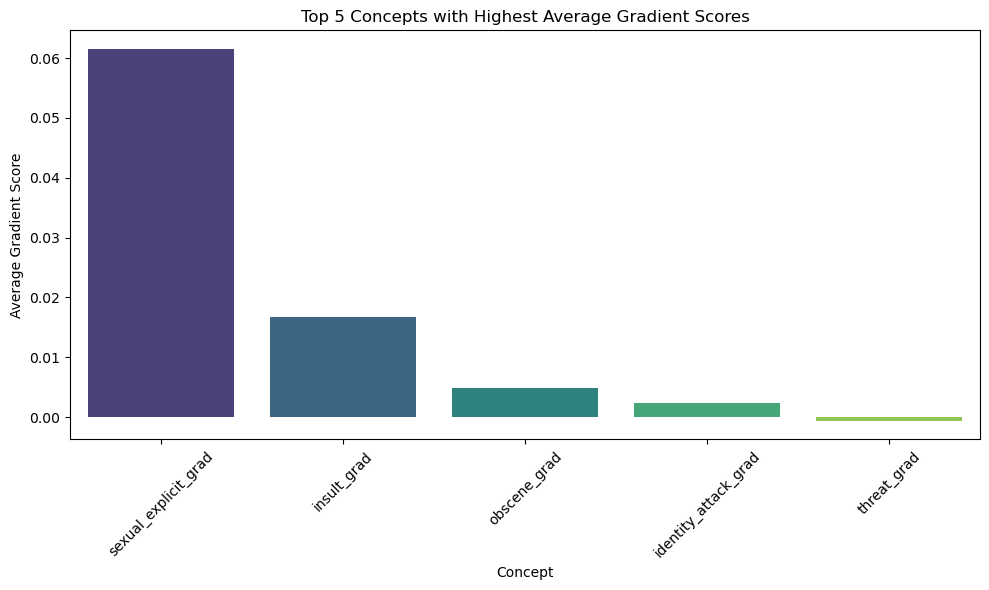

In [131]:
plot_top_concepts(final_df)

In [32]:
pd.set_option('display.max_colwidth', None)
profanity_sentences.keys()

dict_keys(['Trumplethinskin', 'fake', 'trashy', 'sexually', 'hoosegow', 'Reichstag', 'Nazi', 'ISIS', 'Islamophobia', 'Dumbya', 'Supremacists', 'Slovenian', 'Homo', 'neo-BroederBond', 'Boggle', 'lifeofthedelayed', 'pussy', 'Yikes', 'Nazis', 'Buffoon-in-Chief', 'Ob0ngo', 'TORTURE', 'Sewer', 'looney', 'Gay', 'takemyabortionpill', 'beheading', 'CUT', 'treasonous', 'billionaire', 'mentally', 'RACIST', 'D--bag', 'Rotten', 'genes', 'hot', 'Soros', 'sexist', 'narrow-minded', 'idiots', 'racists', 'hate', 'degenerate', 'gunmericans', 'turds', 'misogyny', 'Communist', 'white supremacists', 'Twitler', 'sexism', 'Trumpenfuhrer', 'TERRORISTS', 'raped', 'gay-bashing', 'fountains'])

In [135]:
profanity_counts = {}
for word in PROFANITY_WORDS:
    word_pattern = rf'\b{word}\b'
    count = final_df.sentence.str.contains(word_pattern, case=False, na=False, regex=True).sum()
    profanity_counts[word] = count
df_profanity_counts = pd.DataFrame(list(profanity_counts.items()), columns=['Profanity_Word', 'Count'])
df_profanity_counts

,Profanity_Word,Count
0,Trumplethinskin,1
1,fake,4
2,trashy,1
3,sexually,1
4,hoosegow,1
5,Reichstag,1
6,Nazi,3
7,ISIS,4
8,Islamophobia,1
9,Dumbya,1


In [40]:
final_df.shape

(78, 8)